In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import seaborn as sns
#import GMM
from statsmodels.sandbox.regression.gmm import GMM, NonlinearIVGMM, LinearIVGMM
import statsmodels.api as sm
#set seaborn graphics
sns.set()
import warnings
warnings.filterwarnings('ignore')

In [2]:
pathdata = os.getcwd()+'/Data'
os.chdir(pathdata)
df_gdp = pd.read_pickle('un_data.pkl')
df_gdp.index = df_gdp['SurveyDate']
df_gdp = df_gdp.drop('SurveyDate', axis=1)

# load shocks

In [3]:
oisfactors = pd.read_csv('dataset_con.csv')
oisfactors.index = pd.to_datetime(oisfactors['Date'])

#End of period DEFINITION - always take the last shock
mpdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Monetary Event Window')
mpdf.index = mpdf['date']
prdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Press Release Window')
prdf.index = prdf['date']
pcdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Press Conference Window')
pcdf.index = pcdf['date']
pcdf = pd.concat([pcdf, oisfactors], axis = 1)
##get OLS estimate of the OIS 3Y
pcdf1 = pcdf.loc[(pcdf.index>'2001-12-01')&(pcdf.index<'2015-01-01')]
pcdf1 = pcdf1.dropna(subset=['OIS_1M', 'OIS_3M', 'OIS_6M', 'OIS_1Y', 'OIS_2Y', 'OIS_3Y'])
X = sm.add_constant(pcdf1[['OIS_1M', 'OIS_3M', 'OIS_6M', 'OIS_1Y']])
model = sm.OLS(pcdf1['OIS_3Y'], X)
results = model.fit()
#get the residuals and the fitted values
oisnew = pd.DataFrame(results.resid)
oisnew.columns = ['oisnew']
oisnew.index = pcdf1.index
oisnewfitted = pd.DataFrame(results.fittedvalues)
oisnewfitted.columns = ['oisnew_fitted']
oisnewfitted.index = pcdf1.index
pcdf = pd.concat([pcdf, oisnew], axis = 1)
pcdf = pd.concat([pcdf, oisnewfitted], axis = 1)

dates_list = df_gdp.index.unique()
date1=dates_list[0]
date2=dates_list[1]
newdf = mpdf.loc[(mpdf.index<date1)].tail(1)
#tale always the last announcement
for i in range(0, len(dates_list)-1):
    newdfwork = mpdf.loc[(mpdf.index>dates_list[i])&(mpdf.index<dates_list[i+1])].tail(1)
    #print(newdfwork)
    newdf = newdf.append(newdfwork)
newdf.index = dates_list
#repeat same for press conference
dates_list = df_gdp.index.unique()
date1=dates_list[0]
date2=dates_list[1]
newdfpr = prdf.loc[(prdf.index<date1)].tail(1)
for i in range(0, len(dates_list)-1):
    newdfpr = newdfpr.append(prdf.loc[(prdf.index>dates_list[i])&(prdf.index<dates_list[i+1])].tail(1))
newdfpr.index = dates_list

#repeat same for press release
dates_list = df_gdp.index.unique()
date1=dates_list[0]
date2=dates_list[1]
newdfpc = pcdf.loc[(pcdf.index<date1)].tail(1)
for i in range(0, len(dates_list)-1):
    newdfpc = newdfpc.append(pcdf.loc[(pcdf.index>dates_list[i])&(pcdf.index<dates_list[i+1])].tail(1))
newdfpc.index = dates_list

#SUM DEFINITION
#mpdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Monetary Event Window')
#mpdf.index = mpdf['date']
#prdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Press Release Window')
#prdf.index = prdf['date']
#pcdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Press Conference Window')
#pcdf.index = pcdf['date']
dates_list = df_gdp.index.unique()
date1=dates_list[0]
date2=dates_list[1]
newdfsum = mpdf.loc[(mpdf.index<date1)].tail(1)
for i in range(0, len(dates_list)-1):
    newdfworksum = mpdf.loc[(mpdf.index>dates_list[i])&(mpdf.index<dates_list[i+1])].sum()
    newdfsum = newdfsum.append(newdfwork, ignore_index = True)
newdfsum.index = dates_list
#repeat same for press conference
dates_list = df_gdp.index.unique()
date1=dates_list[0]
date2=dates_list[1]
newdfprsum = prdf.loc[(prdf.index<date1)].tail(1)
for i in range(0, len(dates_list)-1):
    newdfprsum = newdfprsum.append(prdf.loc[(prdf.index>dates_list[i])&(prdf.index<dates_list[i+1])].sum(), ignore_index = True)
newdfprsum.index = dates_list

#repeat same for press release
dates_list = df_gdp.index.unique()
date1=dates_list[0]
date2=dates_list[1]
newdfpcsum = pcdf.loc[(pcdf.index<date1)].tail(1)
for i in range(0, len(dates_list)-1):
    newdfpcsum = newdfpcsum.append(pcdf.loc[(pcdf.index>dates_list[i])&(pcdf.index<dates_list[i+1])].sum(),ignore_index = True)
newdfpcsum.index = dates_list

# transform data into differences and means

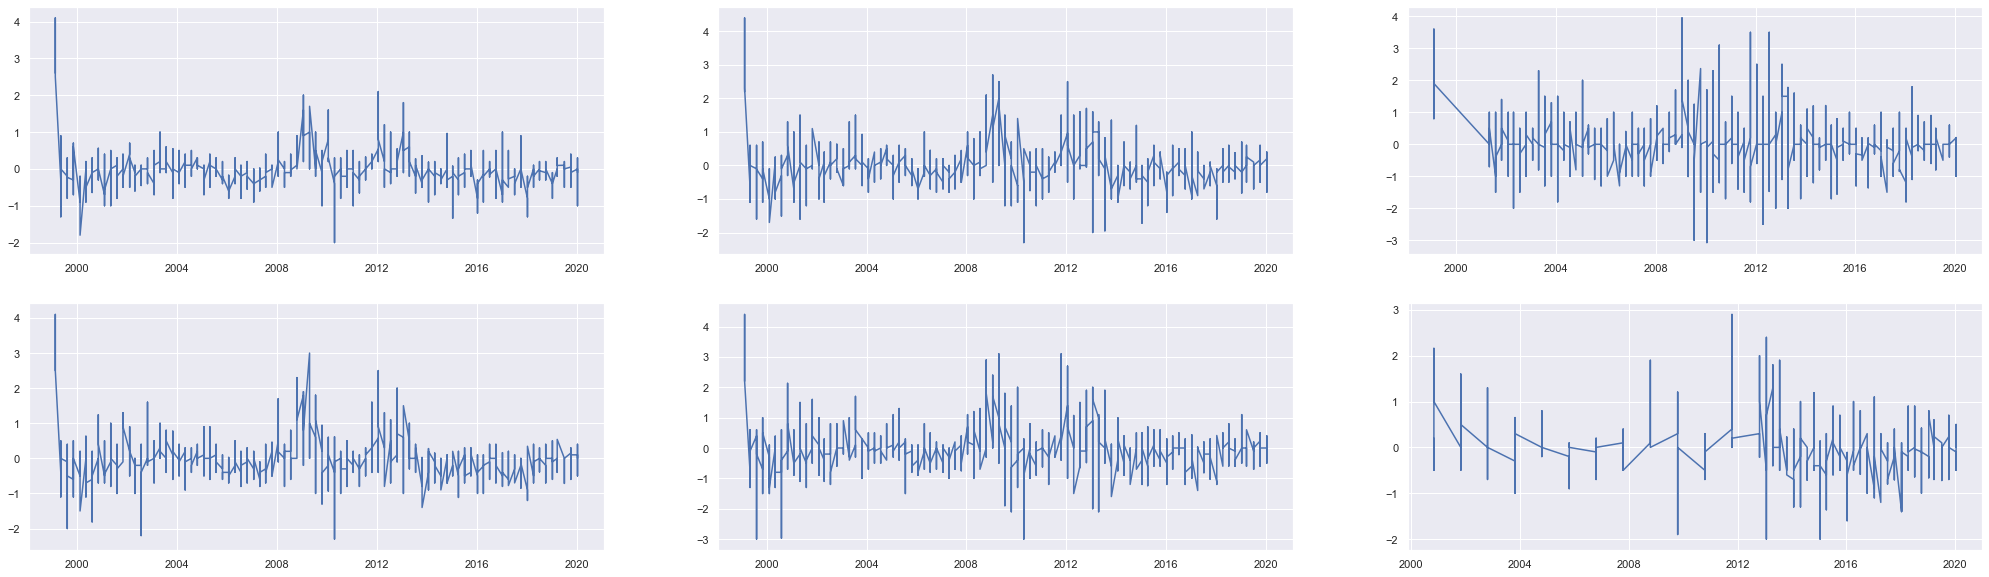

In [5]:
df_gdp['Current Year'] = df_gdp['Current Year'].astype(float)
df_gdp['One Year Ahead'] = df_gdp['One Year Ahead'].astype(float)
df_gdp['Two Years Ahead'] = df_gdp['Two Years Ahead'].astype(float)
df_gdp['Longer Term'] = df_gdp['Longer Term'].astype(float)
df_gdp['Rolling1'] = df_gdp['Rolling1'].astype(float)
df_gdp['Rolling2'] = df_gdp['Rolling2'].astype(float)
dfgdp1 = df_gdp.sort_values(by=['Source', 'SurveyDate'],ascending = [True, True])
dfgdp1['CurrentYearDiff'] = dfgdp1['Current Year'].diff()
dfgdp1['OneYearDiff'] = dfgdp1['One Year Ahead'].diff()
dfgdp1['LongTermDiff'] = dfgdp1['Longer Term'].diff()
dfgdp1['TwoYearDiff'] = dfgdp1['Two Years Ahead'].diff()
dfgdp1['R1'] = dfgdp1['Rolling1'].diff()
dfgdp1['R2'] = dfgdp1['Rolling2'].diff()
dfgdp1 = dfgdp1.sort_index()
#dfgdp1 = dfgdp1.dropna()
#dfgdp1.index = dfgdp1['SurveyDate']
fig, axs = plt.subplots(2, 3, figsize=(35, 10))
axs[0,0].plot(dfgdp1['CurrentYearDiff'].dropna().astype(float))
axs[0,1].plot(dfgdp1['OneYearDiff'].dropna().astype(float))
axs[0,2].plot(dfgdp1['LongTermDiff'].dropna().astype(float))
axs[1,0].plot(dfgdp1['R1'].dropna().astype(float))
axs[1,1].plot(dfgdp1['R2'].dropna().astype(float))
axs[1,2].plot(dfgdp1['TwoYearDiff'].dropna().astype(float))

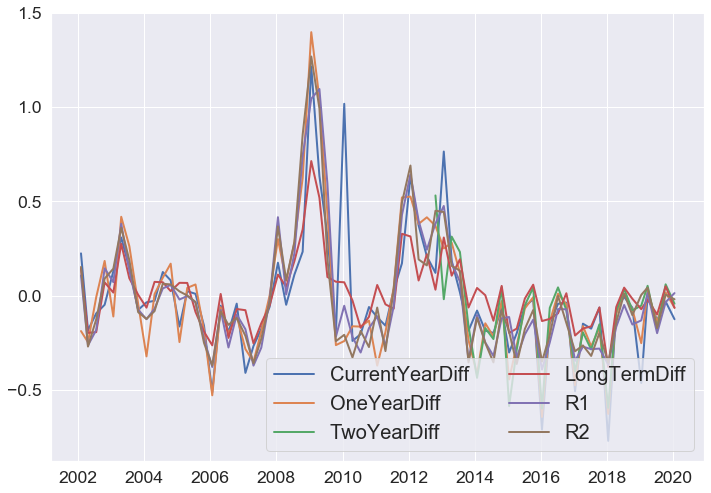

In [6]:
df1gdpmeans = dfgdp1.groupby('SurveyDate')[['CurrentYearDiff','OneYearDiff','TwoYearDiff', 'LongTermDiff', 'R1', 'R2']].mean()
#df1gdpmeans.index = dfgdp1.index.unique()
sns.set(rc={'figure.figsize':(11.7,8.27)}, font_scale=1.6)
plt.plot(df1gdpmeans.loc[df1gdpmeans.index>'2002-01-01'], linewidth=2.0)
plt.legend(list(df1gdpmeans), ncol=2, loc='lower right', fontsize=20);

In [8]:
df1gdpmeans.to_pickle('unr_final.pkl')
newdfpc.to_pickle('OISshocks.pkl')

# GMM class and estimation for 8 IRs - OIS2Y

In [14]:
'''
'''
class mpGMM(GMM):
    
    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 10)
        kwds.setdefault('k_params', 8)
        super(mpGMM, self).__init__(*args, **kwds)


    def momcond(self, params):
        c0, c1, c2, c3, c4, c5, c6, c7 = params
        endog = self.endog
        exog = self.exog
        #defining variables
        #interaction dummies
        dQ1 = exog[:,0]
        dQ2 = exog[:,1]
        dQ3 = exog[:,2]
        dQ4 = exog[:,3]
        dTY = exog[:,4]
        #endogenous variables
        currentY = endog[:,0]
        nextY = endog[:,1]
        twoY = endog[:,2]
        rolling1 = endog[:,3]
        rolling2 = endog[:,4]
        #monetary policy shock
        mp = exog[:,5]
        #next year forecasts
        error11 = dQ1*(nextY-mp*(1/4*c1+1/2*c2+3/4*c3+1*c4+3/4*c5+1/2*c6+1/4*c7))
        error1 = dQ2*(nextY-mp*(1/4*c0+1/2*c1+3/4*c2+1*c3+3/4*c4+1/2*c5+1/4*c6))
        error2 = dQ3*(nextY-mp*(1/2*c0+3/4*c1+1*c2+3/4*c3+1/2*c4+1/4*c5))
        error3 = dQ4*(nextY-mp*(3/4*c0+1*c1+3/4*c2+1/2*c3+1/4*c4))
        #current year forecasts
        error12 = dQ1*(currentY-mp*(c0+3/4*c1+1/2*c2+1/4*c3))
        error4 = dQ2*(currentY-mp*(3/4*c0+1/2*c1+1/4*c2))
        error5 = dQ3*(currentY-mp*(1/2*c0+1/4*c1))
        error6 = dQ4*(currentY-mp*(1/4*c0))
        #rolling forecasts
        #r
        error13 = mp*(rolling1-mp*(c3))
        error14 = mp*(rolling2-mp*(c7))
        g = np.column_stack((error1, error2, error3, error4, error5, error6, 
                            error11, error12, error13, error14))
        return g

#order data
dataols = pd.concat([df1gdpmeans, newdfpc], axis=1)
var = 'OIS_2Y'
dataols = dataols.dropna(subset = [var]).iloc[:-1,:]
#time periods
dataols = dataols.loc[(dataols.index>'2002-01-01')&(dataols.index<'2015-01-01')]
#dataols = dataols.loc[dataols.index>'2002-01-01']
#create dummies
dataols['D1'] = (dataols.index.month.isin([1,2])==True)*1*dataols[var]
dataols['D2'] = (dataols.index.month.isin([3,4])==True)*1*dataols[var]
dataols['D3'] = (dataols.index.month.isin([7,8])==True)*1*dataols[var]
dataols['D4'] = (dataols.index.month.isin([10,11])==True)*1*dataols[var]
dataols['DTY'] = (dataols['TwoYearDiff'].isnull()==False)*1
dataols['TwoYearDiff'] = dataols['TwoYearDiff'].fillna(value=0)
exog = dataols[['D1', 'D2', 'D3', 'D4', 'DTY', var]]
#exog = dataols[[var]]
endog = dataols[['CurrentYearDiff', 'OneYearDiff', 'TwoYearDiff', 'R1', 'R2']].copy()
#instr = np.asarray(exogt.iloc[:, 4:])
model = mpGMM(endog, exog,  None)
beta0 = np.zeros((1, 8))
res = model.fititer(beta0, maxiter=100, optim_method='nm',   weights_method='cov',
                  wargs={'centered':False})
#,  weights_method='cov',
#                    wargs={'centered':False}
w0 = res[1]
inv_weights = np.linalg.inv(w0)
#inv_weights =inv_weights,
res = model.fit(beta0, maxiter=30,   inv_weights =inv_weights, optim_method='nm',   weights_method='cov',
                   wargs={'centered':False})
print(res.summary(yname='UNR forecast diff', xname=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']))

Optimization terminated successfully.
         Current function value: 0.000953
         Iterations: 907
         Function evaluations: 1324
Optimization terminated successfully.
         Current function value: 0.008122
         Iterations: 697
         Function evaluations: 1065
Optimization terminated successfully.
         Current function value: 0.006619
         Iterations: 279
         Function evaluations: 441
Optimization terminated successfully.
         Current function value: 0.006515
         Iterations: 81
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: 0.006514
         Iterations: 84
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: 0.006515
         Iterations: 78
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: 0.202632
         Iterations: 884
         Function evaluations: 1275
Optimization termina

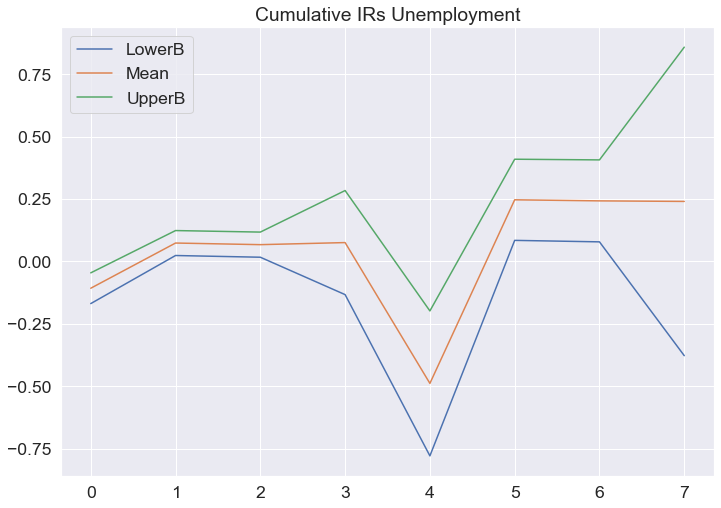

In [9]:
cumsumCI = np.zeros((8, 3))
#first estimate c0
samplesize = 72
mean = res.params[0] 
cov = res.cov_params()[0,0]*samplesize
upB = mean + 1.96*np.sqrt(cov)/np.sqrt(72)
lowB = mean - 1.96*np.sqrt(cov)/np.sqrt(72)
cumsumCI[0, 0] = lowB
cumsumCI[0, 1] = mean
cumsumCI[0, 2] = upB
#we continue for the other coefficients
for i in range(1, 8):
    #get the new mean
    mean = mean + res.params[i]
    #add the variance
    cov = cov + res.cov_params()[i,i]*samplesize
    #add the covariances
    for j in range(0, i):
        cov = cov + 2*res.cov_params()[j,i]*samplesize
    upB = mean + 1.96*np.sqrt(cov)/np.sqrt(72)
    lowB = mean - 1.96*np.sqrt(cov)/np.sqrt(72)
    cumsumCI[i, 0] = lowB
    cumsumCI[i, 1] = mean
    cumsumCI[i, 2] = upB
pd.DataFrame(cumsumCI, columns=['LowerB', 'Mean', 'UpperB'])
plt.plot(pd.DataFrame(cumsumCI, columns=['LowerB', 'Mean', 'UpperB']));
plt.legend(['LowerB', 'Mean', 'UpperB']);
plt.title('Cumulative IRs Unemployment');

# GMM class and estimation for 8 IRs - OIS residuals from regression


In [15]:
'''
'''
class mpGMM(GMM):
    
    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 10)
        kwds.setdefault('k_params', 8)
        super(mpGMM, self).__init__(*args, **kwds)


    def momcond(self, params):
        c0, c1, c2, c3, c4, c5, c6, c7 = params
        endog = self.endog
        exog = self.exog
        #defining variables
        #interaction dummies
        dQ1 = exog[:,0]
        dQ2 = exog[:,1]
        dQ3 = exog[:,2]
        dQ4 = exog[:,3]
        dTY = exog[:,4]
        #endogenous variables
        currentY = endog[:,0]
        nextY = endog[:,1]
        twoY = endog[:,2]
        rolling1 = endog[:,3]
        rolling2 = endog[:,4]
        #monetary policy shock
        mp = exog[:,5]
        #next year forecasts
        error11 = dQ1*(nextY-mp*(1/4*c1+1/2*c2+3/4*c3+1*c4+3/4*c5+1/2*c6+1/4*c7))
        error1 = dQ2*(nextY-mp*(1/4*c0+1/2*c1+3/4*c2+1*c3+3/4*c4+1/2*c5+1/4*c6))
        error2 = dQ3*(nextY-mp*(1/2*c0+3/4*c1+1*c2+3/4*c3+1/2*c4+1/4*c5))
        error3 = dQ4*(nextY-mp*(3/4*c0+1*c1+3/4*c2+1/2*c3+1/4*c4))
        #current year forecasts
        error12 = dQ1*(currentY-mp*(c0+3/4*c1+1/2*c2+1/4*c3))
        error4 = dQ2*(currentY-mp*(3/4*c0+1/2*c1+1/4*c2))
        error5 = dQ3*(currentY-mp*(1/2*c0+1/4*c1))
        error6 = dQ4*(currentY-mp*(1/4*c0))
        #rolling forecasts
        #r
        error13 = mp*(rolling1-mp*(c3))
        error14 = mp*(rolling2-mp*(c7))
        g = np.column_stack((error1, error2, error3, error4, error5, error6, 
                            error11, error12, error13, error14))
        return g

#order data
dataols = pd.concat([df1gdpmeans, newdfpc], axis=1)
var = 'oisnew'
dataols = dataols.dropna(subset = [var]).iloc[:-1,:]
#time periods
dataols = dataols.loc[(dataols.index>'2002-01-01')&(dataols.index<'2015-01-01')]
#dataols = dataols.loc[dataols.index>'2002-01-01']
#create dummies
dataols['D1'] = (dataols.index.month.isin([1,2])==True)*1*dataols[var]
dataols['D2'] = (dataols.index.month.isin([3,4])==True)*1*dataols[var]
dataols['D3'] = (dataols.index.month.isin([7,8])==True)*1*dataols[var]
dataols['D4'] = (dataols.index.month.isin([10,11])==True)*1*dataols[var]
dataols['DTY'] = (dataols['TwoYearDiff'].isnull()==False)*1
dataols['TwoYearDiff'] = dataols['TwoYearDiff'].fillna(value=0)
exog = dataols[['D1', 'D2', 'D3', 'D4', 'DTY', var]]
#exog = dataols[[var]]
endog = dataols[['CurrentYearDiff', 'OneYearDiff', 'TwoYearDiff', 'R1', 'R2']].copy()
#instr = np.asarray(exogt.iloc[:, 4:])
model = mpGMM(endog, exog,  None)
beta0 = np.zeros((1, 8))
res = model.fititer(beta0, maxiter=100, optim_method='nm',   weights_method='cov',
                  wargs={'centered':False})
#,  weights_method='cov',
#                    wargs={'centered':False}
w0 = res[1]
inv_weights = np.linalg.inv(w0)
#inv_weights =inv_weights,
res = model.fit(beta0, maxiter=30,   inv_weights =inv_weights, optim_method='nm',   weights_method='cov',
                   wargs={'centered':False})
print(res.summary(yname='UNR forecast diff', xname=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']))

Optimization terminated successfully.
         Current function value: 0.007641
         Iterations: 340
         Function evaluations: 511
Optimization terminated successfully.
         Current function value: 0.091194
         Iterations: 504
         Function evaluations: 750
Optimization terminated successfully.
         Current function value: 0.084605
         Iterations: 1083
         Function evaluations: 1575
Optimization terminated successfully.
         Current function value: 0.085585
         Iterations: 599
         Function evaluations: 894
Optimization terminated successfully.
         Current function value: 0.085752
         Iterations: 701
         Function evaluations: 1043
Optimization terminated successfully.
         Current function value: 0.085963
         Iterations: 895
         Function evaluations: 1345
Optimization terminated successfully.
         Current function value: 0.086187
         Iterations: 876
         Function evaluations: 1305
Optimization te

Optimization terminated successfully.
         Current function value: 0.087258
         Iterations: 83
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: 0.087270
         Iterations: 108
         Function evaluations: 189
Optimization terminated successfully.
         Current function value: 0.087277
         Iterations: 89
         Function evaluations: 159
                                mpGMM Results                                 
Dep. Variable:      UNR forecast diff   Hansen J:                        4.189
Model:                          mpGMM   Prob (Hansen J):                 0.123
Method:                           GMM                                         
Date:                Sun, 27 Sep 2020                                         
Time:                        22:18:48                                         
No. Observations:                  48                                         
                 coef    std 

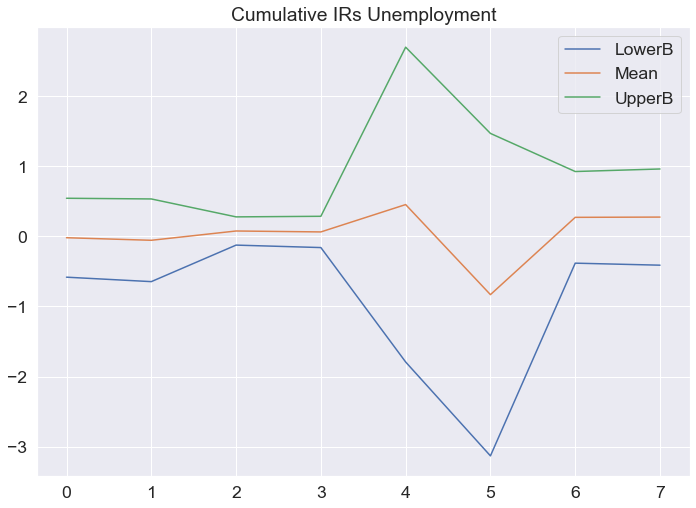

In [16]:
cumsumCI = np.zeros((8, 3))
#first estimate c0
samplesize = 72
mean = res.params[0] 
cov = res.cov_params()[0,0]*samplesize
upB = mean + 1.96*np.sqrt(cov)/np.sqrt(72)
lowB = mean - 1.96*np.sqrt(cov)/np.sqrt(72)
cumsumCI[0, 0] = lowB
cumsumCI[0, 1] = mean
cumsumCI[0, 2] = upB
#we continue for the other coefficients
for i in range(1, 8):
    #get the new mean
    mean = mean + res.params[i]
    #add the variance
    cov = cov + res.cov_params()[i,i]*samplesize
    #add the covariances
    for j in range(0, i):
        cov = cov + 2*res.cov_params()[j,i]*samplesize
    upB = mean + 1.96*np.sqrt(cov)/np.sqrt(72)
    lowB = mean - 1.96*np.sqrt(cov)/np.sqrt(72)
    cumsumCI[i, 0] = lowB
    cumsumCI[i, 1] = mean
    cumsumCI[i, 2] = upB
pd.DataFrame(cumsumCI, columns=['LowerB', 'Mean', 'UpperB'])
plt.plot(pd.DataFrame(cumsumCI, columns=['LowerB', 'Mean', 'UpperB']));
plt.legend(['LowerB', 'Mean', 'UpperB']);
plt.title('Cumulative IRs Unemployment');

# Estimation with FG factor (paper)

In [17]:
'''
'''
class mpGMM(GMM):
    
    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 10)
        kwds.setdefault('k_params', 8)
        super(mpGMM, self).__init__(*args, **kwds)


    def momcond(self, params):
        c0, c1, c2, c3, c4, c5, c6, c7 = params
        endog = self.endog
        exog = self.exog
        #defining variables
        #interaction dummies
        dQ1 = exog[:,0]
        dQ2 = exog[:,1]
        dQ3 = exog[:,2]
        dQ4 = exog[:,3]
        dTY = exog[:,4]
        #endogenous variables
        currentY = endog[:,0]
        nextY = endog[:,1]
        twoY = endog[:,2]
        rolling1 = endog[:,3]
        rolling2 = endog[:,4]
        #monetary policy shock
        mp = exog[:,5]
        #next year forecasts
        error11 = dQ1*(nextY-mp*(1/4*c1+1/2*c2+3/4*c3+1*c4+3/4*c5+1/2*c6+1/4*c7))
        error1 = dQ2*(nextY-mp*(1/4*c0+1/2*c1+3/4*c2+1*c3+3/4*c4+1/2*c5+1/4*c6))
        error2 = dQ3*(nextY-mp*(1/2*c0+3/4*c1+1*c2+3/4*c3+1/2*c4+1/4*c5))
        error3 = dQ4*(nextY-mp*(3/4*c0+1*c1+3/4*c2+1/2*c3+1/4*c4))
        #current year forecasts
        error12 = dQ1*(currentY-mp*(c0+3/4*c1+1/2*c2+1/4*c3))
        error4 = dQ2*(currentY-mp*(3/4*c0+1/2*c1+1/4*c2))
        error5 = dQ3*(currentY-mp*(1/2*c0+1/4*c1))
        error6 = dQ4*(currentY-mp*(1/4*c0))
        #rolling forecasts
        #r
        error13 = mp*(rolling1-mp*(c3))
        error14 = mp*(rolling2-mp*(c7))
        g = np.column_stack((error1, error2, error3, error4, error5, error6, 
                            error11, error12, error13, error14))
        return g

#order data
dataols = pd.concat([df1gdpmeans, newdfpc], axis=1)
var = 'ConfFactor2'
dataols = dataols.dropna(subset = [var]).iloc[:-1,:]
#time periods
dataols = dataols.loc[(dataols.index>'2002-01-01')&(dataols.index<'2015-01-01')]
#dataols = dataols.loc[dataols.index>'2002-01-01']
#create dummies
dataols['D1'] = (dataols.index.month.isin([1,2])==True)*1*dataols[var]
dataols['D2'] = (dataols.index.month.isin([3,4])==True)*1*dataols[var]
dataols['D3'] = (dataols.index.month.isin([7,8])==True)*1*dataols[var]
dataols['D4'] = (dataols.index.month.isin([10,11])==True)*1*dataols[var]
dataols['DTY'] = (dataols['TwoYearDiff'].isnull()==False)*1
dataols['TwoYearDiff'] = dataols['TwoYearDiff'].fillna(value=0)
exog = dataols[['D1', 'D2', 'D3', 'D4', 'DTY', var]]
#exog = dataols[[var]]
endog = dataols[['CurrentYearDiff', 'OneYearDiff', 'TwoYearDiff', 'R1', 'R2']].copy()
#instr = np.asarray(exogt.iloc[:, 4:])
model = mpGMM(endog, exog,  None)
beta0 = np.zeros((1, 8))
res = model.fititer(beta0, maxiter=100, optim_method='nm',   weights_method='cov',
                  wargs={'centered':False})
#,  weights_method='cov',
#                    wargs={'centered':False}
w0 = res[1]
inv_weights = np.linalg.inv(w0)
#inv_weights =inv_weights,
res = model.fit(beta0, maxiter=30,   inv_weights =inv_weights, optim_method='nm',   weights_method='cov',
                   wargs={'centered':False})
print(res.summary(yname='UNR forecast diff', xname=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']))

Optimization terminated successfully.
         Current function value: 0.007174
         Iterations: 656
         Function evaluations: 956
Optimization terminated successfully.
         Current function value: 0.029311
         Iterations: 244
         Function evaluations: 385
Optimization terminated successfully.
         Current function value: 0.029234
         Iterations: 283
         Function evaluations: 454
Optimization terminated successfully.
         Current function value: 0.029238
         Iterations: 86
         Function evaluations: 160
Optimization terminated successfully.
         Current function value: 0.179582
         Iterations: 538
         Function evaluations: 802
Optimization terminated successfully.
         Current function value: 0.029330
         Iterations: 253
         Function evaluations: 412
Optimization terminated successfully.
         Current function value: 0.029228
         Iterations: 359
         Function evaluations: 554
Optimization terminat

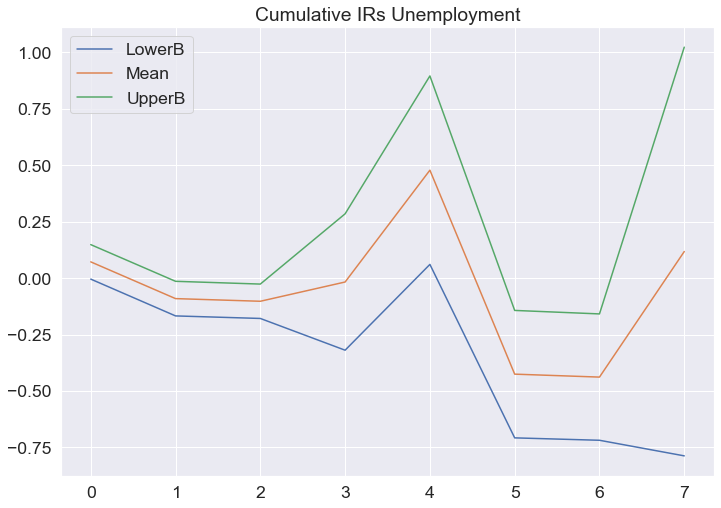

In [13]:
cumsumCI = np.zeros((8, 3))
#first estimate c0
samplesize = 72
mean = res.params[0] 
cov = res.cov_params()[0,0]*samplesize
upB = mean + 1.96*np.sqrt(cov)/np.sqrt(72)
lowB = mean - 1.96*np.sqrt(cov)/np.sqrt(72)
cumsumCI[0, 0] = lowB
cumsumCI[0, 1] = mean
cumsumCI[0, 2] = upB
#we continue for the other coefficients
for i in range(1, 8):
    #get the new mean
    mean = mean + res.params[i]
    #add the variance
    cov = cov + res.cov_params()[i,i]*samplesize
    #add the covariances
    for j in range(0, i):
        cov = cov + 2*res.cov_params()[j,i]*samplesize
    upB = mean + 1.96*np.sqrt(cov)/np.sqrt(72)
    lowB = mean - 1.96*np.sqrt(cov)/np.sqrt(72)
    cumsumCI[i, 0] = lowB
    cumsumCI[i, 1] = mean
    cumsumCI[i, 2] = upB
pd.DataFrame(cumsumCI, columns=['LowerB', 'Mean', 'UpperB'])
plt.plot(pd.DataFrame(cumsumCI, columns=['LowerB', 'Mean', 'UpperB']));
plt.legend(['LowerB', 'Mean', 'UpperB']);
plt.title('Cumulative IRs Unemployment');